<a href="https://colab.research.google.com/github/seschm/Internship-Gaertner/blob/main/Relevant_NN_for_IC_POVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax import jit, vmap, pmap, grad
from jax import random
import flax
from flax import linen as nn
from flax.training import train_state
import optax
import torch.utils.data as data
from functools import partial

import itertools

from tqdm.auto import tqdm
import random as rng

import numpy as np
import scipy as sp
from numpy import sqrt, cos, sin, exp, pi, log2
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import unitary_group
from scipy.stats import norm

In [2]:
def generate_random_pure_state(nQubit):
    """
    Generates Haar random pure state.
    To generate a random pure state, take any basis state, e.g. |00...00>
    and apply a random unitary matrix. For consistency each basis state should be the same.
    """
    baseRho=np.zeros((2**nQubit,2**nQubit),dtype=complex)
    baseRho[0,0]=1
    U=unitary_group.rvs(2**nQubit)
    return U@baseRho@U.conj().T

In [3]:
def generate_single_qubit(theta,phi):
    """
    Generates single qubit out of the given angles theta and phi.
    First construct the single qubit state as an array of shape (2, 1).
    Then compute the matrixproduct with its adjoint state.
    """
    state = np.array([[cos(theta/2)],[sin(theta/2)*exp(phi*1.j)]])
    return state@state.conj().T

In [4]:
def generate_random_seperable_pure_state(nQubit):
    """
    Generates random seperable pure state.
    First generate the desired number of random pure states.
    Then tensor them together.
    """
    single_qubits = []
    for i in range(0,nQubit):
        single_qubits.append(generate_random_pure_state(1))
    tensored_qubits = [single_qubits[0]]
    for i in range(1,nQubit):
        tensored_qubits.append(np.kron(tensored_qubits[-1],single_qubits[i]))
    return tensored_qubits[-1]

In [5]:
def depolarizing_channel(state,p):
    """
    Applies a depolarizing channel to the given state with p the probability of the completely mixed state.
    """
    d=len(state[0])
    return p*np.eye(d)/d+(1-p)*state

In [6]:
def generate_POVM(theta,phi,nQubit):
    """
    Generates a POVM consisting of multi qubit projectors on to the axis defined by the two angles theta and phi.
    First generates all possible states (combinations of spin up and down) as strings containing 1s and 0s.
    The order is equal to binary counting.
    Then generates the single qubit projector and its orthogonal projector.
    In the next step all single qubit projectors corresponding to the same state are gathered in the correct order and then tensored together to get an element of the POVM.
    Returns the POVM with the elements beeing ordered equal to binary counting (-> up ... up, up ... up down, up ... up down up, ...).
    """
    up_and_downs = []

    for i in range(2**nQubit):
        binary = bin(i)[2:]
        zeros = np.zeros(nQubit-len(binary), dtype=int)
        for k in range(nQubit-len(binary)):
            binary = '0' + binary
        up_and_downs.append(binary)

    projector=generate_single_qubit(theta,phi)
    orthogonal_projector = np.eye(2)-projector
    POVM = []

    for i in range(2**nQubit):
        tensored_projector = []
        single_projectors = []
        for j in range(nQubit):
            if up_and_downs[i][j] == '0':
                single_projectors.append(projector)
            if up_and_downs[i][j] == '1':
                single_projectors.append(orthogonal_projector)
        tensored_projector.append(single_projectors[0])
        for k in range(nQubit-1):
            tensored_projector.append(np.kron(tensored_projector[-1],single_projectors[k+1]))
        POVM.append(tensored_projector[-1])

    return POVM

In [7]:
def generate_pauli6(nQubits):
    """
    Generates the Pauli 6 for n qubits.
    First define the Pauli 6 for a single qubit.
    Then determine all possible combinations of the Pauli 6 matrices for the given qubit number.
    Then tensor all combinations together.
    """

    # Define Pauli 6 for single qubit
    X_plus = generate_single_qubit(pi/2,0)
    X_minus = np.eye(2)-X_plus
    Y_plus = generate_single_qubit(pi/2,pi/2)
    Y_minus = np.eye(2)-Y_plus
    Z_plus = generate_single_qubit(0,0)
    Z_minus = np.eye(2)-Z_plus

    # Create lists to iter through
    paulis = [X_plus,X_minus,Y_plus,Y_minus,Z_plus,Z_minus]
    indices = [0,1,2,3,4,5]
    ref_list_temp = []

    # Determine all possible combinations of the indices in the list "indices" with the length nQubits
    for comb in itertools.combinations_with_replacement(indices, nQubits):
        # Generate all permutations of the combination
        for perm in itertools.permutations(comb):
            ref_list_temp.append(perm)

    ref_list = list(dict.fromkeys(ref_list_temp))
    POVM = []

    # For all the possible index combinations tensor the coresponding Pauli matrices together
    for index, comb in enumerate(ref_list):
        POVM.append(paulis[comb[0]])
        for i in range(1,nQubits):
            POVM[index] = np.kron(POVM[index],paulis[comb[i]])

    return POVM

In [8]:
def perform_multi_qubit_measurement(state,POVM):
    """
    Performs a multi qubit measurement with the given POVM.
    The probabilities are real numbers, therefore the imaginary part gets discarded (checked, that it is negligible small)
    """
    probabilities = np.einsum('lii->l',np.einsum('ij,ljk->lik',state,POVM,optimize=True))
    return np.real(probabilities)

In [9]:
def perform_noisy_multi_qubit_measurement(state,POVM,p):
    """
    Generates probabilities of the noisy state.
    First applies the noise, then generates the probabilities.
    """
    noisy_state = depolarizing_channel(state,p)
    return perform_multi_qubit_measurement(noisy_state,POVM)

In [10]:
def cholesky_decomposition(state):
    """
    Determines the cholesky decomposition for the given state.
    (Better to use np.linalg.cholesky(state))
    """
    n = len(state)
    A = np.zeros_like(state)

    for i in range(n):
        for j in range(i+1):
            if i == j:
                A[i][j] = np.sqrt(state[i][i] - np.sum(A[i][:j]**2))
            else:
                A[i][j] = (state[i][j] - np.sum(A[i][:j]*A[j][:j])) / A[j][j]

    return A

In [11]:
def sampling(probabilities,samplesize):
    """
    Takes in a probability distribution and samples from it.
    """
    sampling = rng.choices(np.arange(0,len(probabilities)), weights=probabilities, k=samplesize)
    sampled_probabilities = []
    for element in np.arange(0,len(probabilities)):
        sampled_probabilities.append(sampling.count(element)/samplesize)
    return sampled_probabilities

In [12]:
@partial(jit,static_argnums=(4,5))  # Jit the function for efficiency
def loss_fn(state, params, batch_input, batch_target_output,nQubits,batch_size):
    """
    Determines the quantum infidelity as loss (code only works for pure states as target output values).
    Therefore the output is used to get the cholesky coefficients.
      First run the given batch for the current weights and biases (params) through the NN.
      Then reshape these predictions in 2^n x 2^n matrices (do that for each state of the batch).
      Then add the transposed of this matrix times i to this matrix.
      Set all elements in the upper triangular to zero, by multiplying this matrix with a lower triangular matrix (all non-zero elements are ones) elementwise.
      Discard the imaginary part of the diagonal elements.
    From the cholesky decompostion the density matrix is calculated: rho = A*A^dagger / trace(A*A^dagger)
    Calculate the quantum infidelty for this density matrix and the desired non-noisy density matrix (which is a pure state).
    """
    pred = state.apply_fn(params, batch_input)

    B = jnp.reshape(jnp.asarray(pred),(batch_size,2**nQubits,2**nQubits))
    #C = jnp.einsum('ijk,ilk->ijl',B,1.j*B)
    O = jnp.einsum('ijk->ikj',B)
    C = B + 1.j*O
    Tri = jnp.tril(jnp.ones((batch_size,2**nQubits,2**nQubits)))
    D = jnp.multiply(C,Tri)
    Re_Diag = jnp.real(jnp.diagonal(D, axis1=-2, axis2=-1))
    A = jnp.copy(D)
    A = A.at[..., jnp.arange(2**nQubits), jnp.arange(2**nQubits)].set(Re_Diag)

    #A = jnp.zeros((batch_size,2**nQubits,2**nQubits), dtype=complex)
    #for k in range(batch_size):            # state
    #    counter = 0
    #    for j in range(2**nQubits):        # row
    #        for i in range(2**nQubits):    # column
    #            if i < j:
    #                A = A.at[k,j,i].set(pred[k,counter]+pred[k,counter+1]*1.j)
    #                counter += 2
    #            if i == j:
    #                A = A.at[k,j,i].set(pred[k,counter])
    #                counter += 1
    pred_den_unn = jnp.einsum('ijk,ilk->ijl',A,A.conj())
    trace_inv = 1/ jnp.trace(pred_den_unn,axis1=1,axis2=2)
    pred_den = jnp.einsum('ijk,i->ijk',pred_den_unn,trace_inv)
    matrix_product = jnp.einsum('ijk,ikl->ijl',pred_den,batch_target_output)
    loss = jnp.mean(1-jnp.trace(matrix_product,axis1=1,axis2=2))
    return jax.lax.real(loss)

In [13]:
@partial(jit,static_argnums=(3,4))  # Jit the function for efficiency
def train_step(state, batch_input, batch_target_output,nQubit,batch_size):
    """
    Performs one training step of the network and returns the updated weights and biases (contained in state)
    """
    # Gradient function
    grad_fn = jax.value_and_grad(loss_fn,# Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                )
    # Determine gradients for current model, parameters and batch
    loss, grads = grad_fn(state, state.params, batch_input, batch_target_output,nQubit,batch_size)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss

In [14]:
def train_model(state, batched_training_input, batched_training_target_outputs, acc_input, acc_target_output, batched_te_unm_den,nQubits,batch_size, num_epochs = 100):
  """
  Trains the network for num_epochs epochs.
  Also calculates the different accuracies after each training step.
  """

  # Lists to be filled with the accuracy of the test, training and unmitigated data
  # The accuracy in this case equals the loss, so it's the quantum infidelity
  acc = []
  acc_train = []
  acc_unmit = []


  # for each epoch updates the paramters for each batch of the training data
  for epoch in tqdm(range(num_epochs)):
    acc_train_temp = []
    acc_temp = []
    acc_unmit_temp = []
    # Updating the parameters for each batch
    for i in range(len(batched_training_input)):
        state, loss = train_step(state, batched_training_input[i], batched_training_target_outputs[i],nQubits,batch_size)
    # Calculating the accuracy for the batches of the training data
    for i in range(len(batched_training_input)):
        acc_train_temp.append(loss_fn(state,state.params,batched_training_input[i], batched_training_target_outputs[i],nQubits,batch_size))
    # Calculating the accuracy for the test and unmitigated data
    for j in range(len(acc_input)):
        acc_temp.append(loss_fn(state,state.params,acc_input[j], acc_target_output[j],nQubits,batch_size))
        matrix_product = jnp.einsum('ijk,ikl->ijl',batched_te_unm_den[j],acc_target_output[j])
        #print('product',matrix_product[-1])
        #print('trace',jnp.trace(matrix_product,axis1=1,axis2=2)[-1])                   # checking the size of the imaginary part -> order of 10^-9
        acc_unmit_temp.append(jnp.real(1-jnp.trace(matrix_product,axis1=1,axis2=2)))    # taking the real part, because imaginary part is probably left because of computational accuracy
    # Calculating the mean accuracy over all batches
    acc_train.append(jnp.mean(jnp.asarray(acc_train_temp)))
    acc.append(jnp.mean(jnp.asarray(acc_temp)))
    acc_unmit.append(jnp.mean(jnp.asarray(acc_unmit_temp)))

  return state, acc, acc_train, acc_unmit

In [15]:
def shuffle_along_axis0(arr):
    """
    Shuffles an array along the axis 0.
    """
    rng_key = jax.random.PRNGKey(0)  # Initialize random number generator key
    permuted_indices = jax.random.permutation(rng_key, arr.shape[0])
    shuffled_arr = jnp.take(arr, permuted_indices, axis=0)
    return shuffled_arr

In [16]:
class MLP(nn.Module):
  """
  Defining features of the network (e.g. activation function)
  """
  num_neurons_per_layer : list[int]   # List containing the number of neurons per layer (except input layer)

  @nn.compact
  def __call__(self, x):
    activation = x
    for i, numb_neurons in enumerate(self.num_neurons_per_layer):
      activation = nn.Dense(numb_neurons)(activation)
      if i != len(self.num_neurons_per_layer) - 1:
        activation = nn.relu(activation) # using a relu activation function for all but the last layer

    return activation

In [17]:
# Set all variables that need to be preselected
nQubit_list = [2,3,4,5]
training_states_list = [2500,5000,10000,20000]
num_epochs = 300
batch_size = 100
learning_rate = 0.001
test_states = 200
theta = 0
phi = 0
p = 0.15
samplesize = 10000

# Lists for storing the accuracies
acc_test_list = []
acc_train_list = []
acc_unmit_list = []

for i in range(0,4):
    nQubit = nQubit_list[i]
    layers_list = [[20,20,20,20,20,4**nQubit],[40,40,4**nQubit],[80,80,80,80,80,80,80,4**nQubit],[160,160,160,160,160,4**nQubit]]
    layers = layers_list[i]
    training_states = training_states_list[i]

    model = MLP(num_neurons_per_layer=layers)                                                     # Initialize network
    x_key, init_key = random.split(random.PRNGKey(0))
    x = random.normal(x_key, (batch_size, 6**nQubit))                                             # Batch size 100, input size 2
    params = model.init(init_key, x)                                                              # Initialize network params (biases being initialized as zeros)
    optimizer = optax.adam(learning_rate=learning_rate)                                           # selecting an optimizer with a certain learning rate
    # Not exactly sure how train_state modul works
    # a train state contains the current parameters (weights, biases) and the optimizer
    model_state = train_state.TrainState.create(apply_fn=model.apply,params=params,tx=optimizer)

    POVM = generate_pauli6(nQubit)                                            # Generating Pauli 6 for the given Qubit number

    # Lists for storing generated data
    training_probs = []
    training_den = []
    test_probs = []
    test_unm_den = []
    test_den = []

    # Generating training data
    for i in tqdm(range(training_states)):
        state = generate_random_seperable_pure_state(nQubit)
        training_den.append(state)
        noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
        training_probs.append(noisy_probs)                                  # -> used if no sampling is needed
        #noisy_probs_sampled = sampling(noisy_probs,samplesize)             # takes too long with sampling
        #training_probs.append(noisy_probs_sampled)

    # Generating test data
    for i in tqdm(range(test_states)):
        state = generate_random_seperable_pure_state(nQubit)
        test_den.append(state)
        noisy_state = depolarizing_channel(state,p)
        test_unm_den.append(noisy_state)
        noisy_probs = perform_noisy_multi_qubit_measurement(state,POVM,p)
        test_probs.append(noisy_probs)                                      # -> used if no sampling is needed
        #noisy_probs_sampled = sampling(noisy_probs,samplesize)             # takes too long with sampling
        #test_probs.append(noisy_probs_sampled)

    # Shuffle the generated data (shouldn't be necessary)
    training_probs_shuf = shuffle_along_axis0(jnp.asarray(training_probs))
    training_As_shuf = shuffle_along_axis0(jnp.asarray(training_den))
    test_probs_shuf = shuffle_along_axis0(jnp.asarray(test_probs))
    test_As_shuf = shuffle_along_axis0(jnp.asarray(test_den))
    test_unm_As_shuf = shuffle_along_axis0(jnp.asarray(test_unm_den))

    # batching the generated data
    batched_tr_probs = jnp.split(training_probs_shuf,int(len(training_probs_shuf)/batch_size),axis=0)
    batched_tr_As = jnp.split(training_As_shuf,int(len(training_As_shuf)/batch_size),axis=0)
    batched_te_probs = jnp.split(test_probs_shuf,int(len(test_probs_shuf)/batch_size),axis=0)
    batched_te_As = jnp.split(test_As_shuf ,int(len(test_As_shuf)/batch_size),axis=0)
    batched_te_unm_As = jnp.split(test_unm_As_shuf ,int(len(test_unm_As_shuf)/batch_size),axis=0)

    # Training the NN
    state, acc, acc_train, acc_unmit = train_model(model_state, jnp.asarray(batched_tr_probs), jnp.asarray(batched_tr_As),
                                                               jnp.asarray(batched_te_probs), jnp.asarray(batched_te_As),
                                                               jnp.asarray(batched_te_unm_As),
                                                              nQubits=nQubit,batch_size=batch_size, num_epochs = num_epochs)
    # Saving the accuracies
    acc_test_list.append(acc)
    acc_train_list.append(acc_train)
    acc_unmit_list.append(acc_unmit)

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

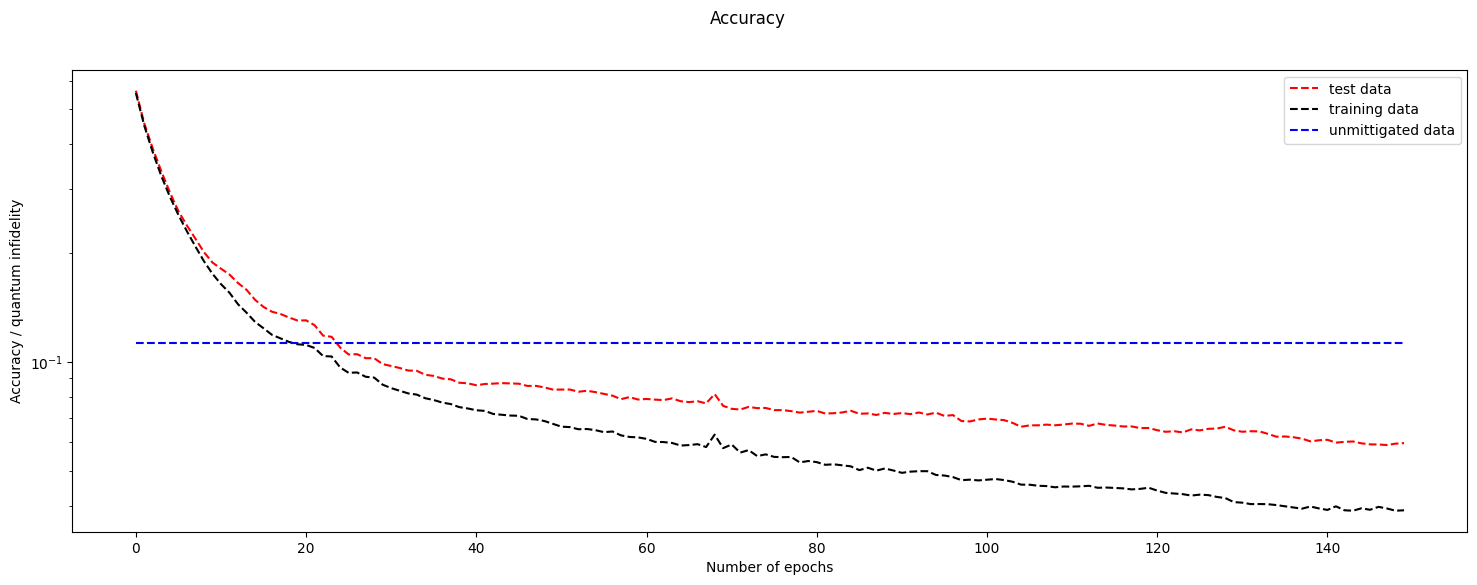

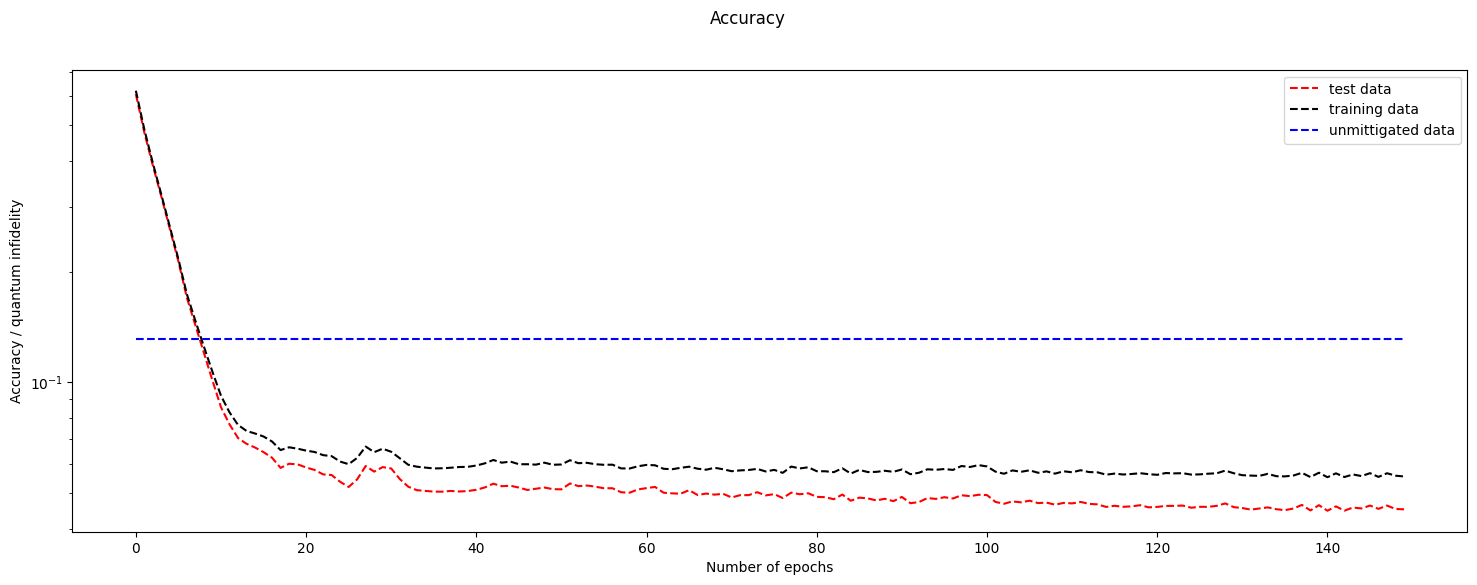

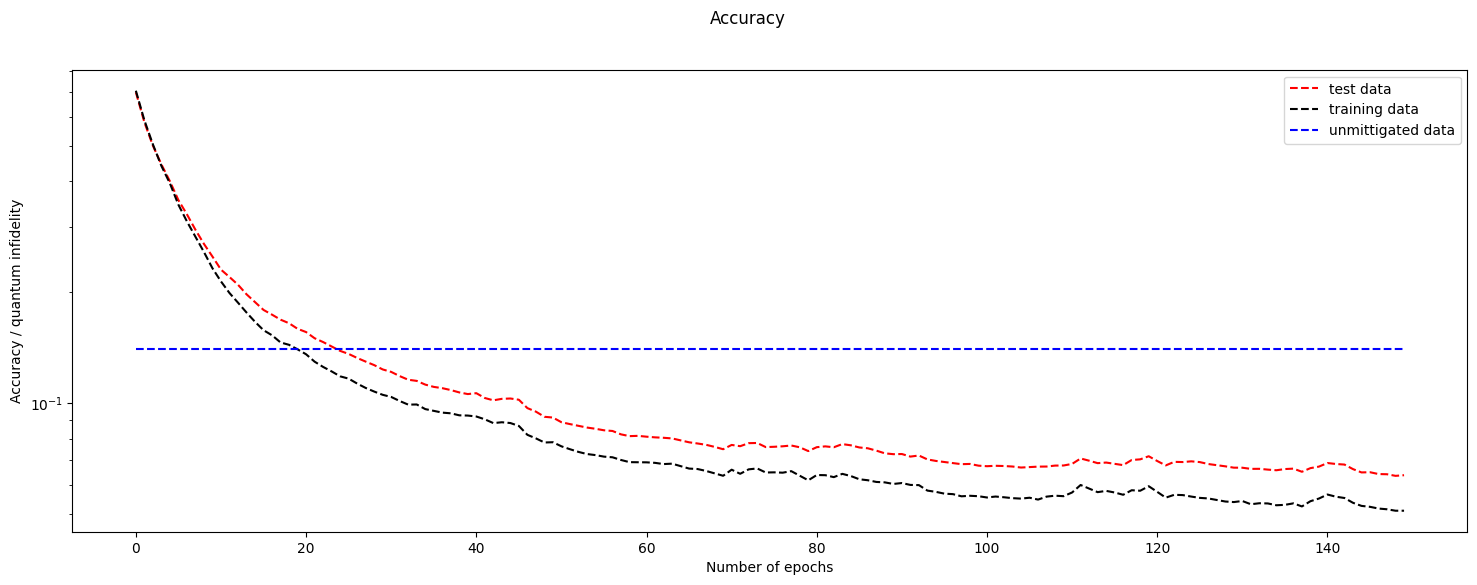

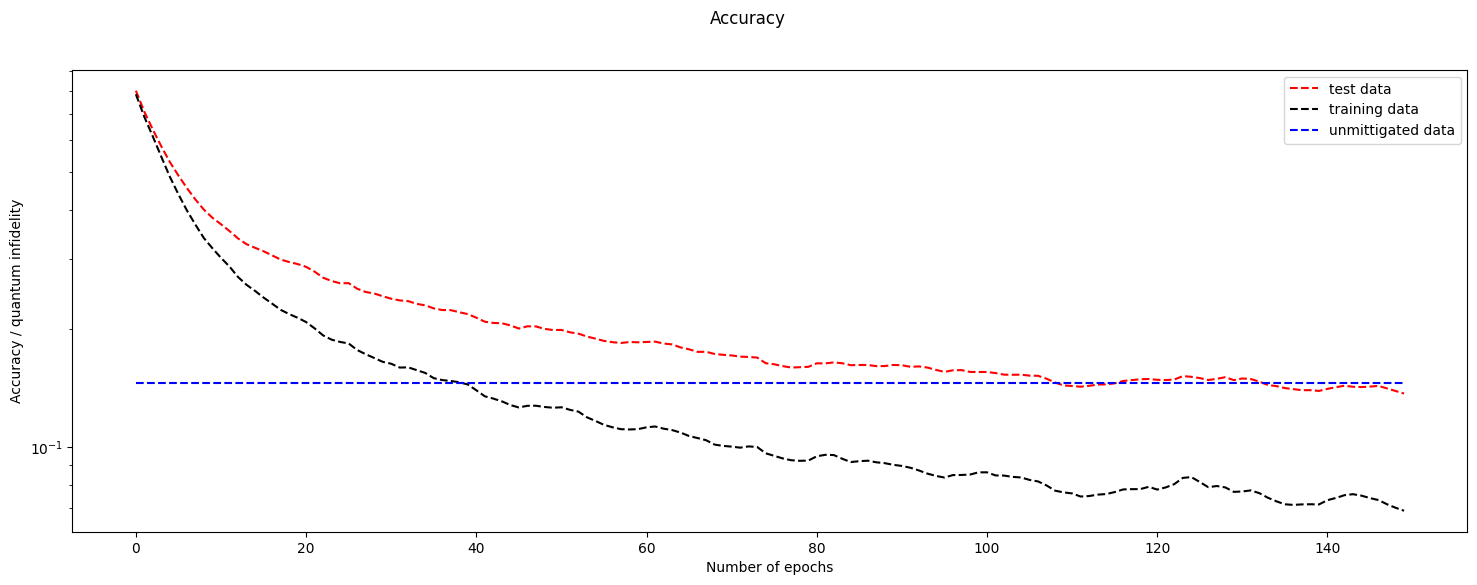

In [18]:
# Plotting the NN accurcies over the number of epochs
i = np.arange(0,num_epochs)

for j in range(0,4):
    fig, ax = plt.subplots(figsize=(18, 6))
    ax.plot(i,acc_test_list[j],label="test data",linestyle="--",color="red")
    ax.plot(i,acc_train_list[j],label="training data",linestyle="--",color="black")
    ax.plot(i,acc_unmit_list[j],label="unmittigated data",linestyle="--",color="blue")
    ax.set_xlabel('Number of epochs')
    ax.set_ylabel('Accuracy / quantum infidelity')
    ax.set_yscale('log')
    ax.legend()
    fig.suptitle('Accuracy')

Text(0.5, 0.98, 'NN for IC-POVM')

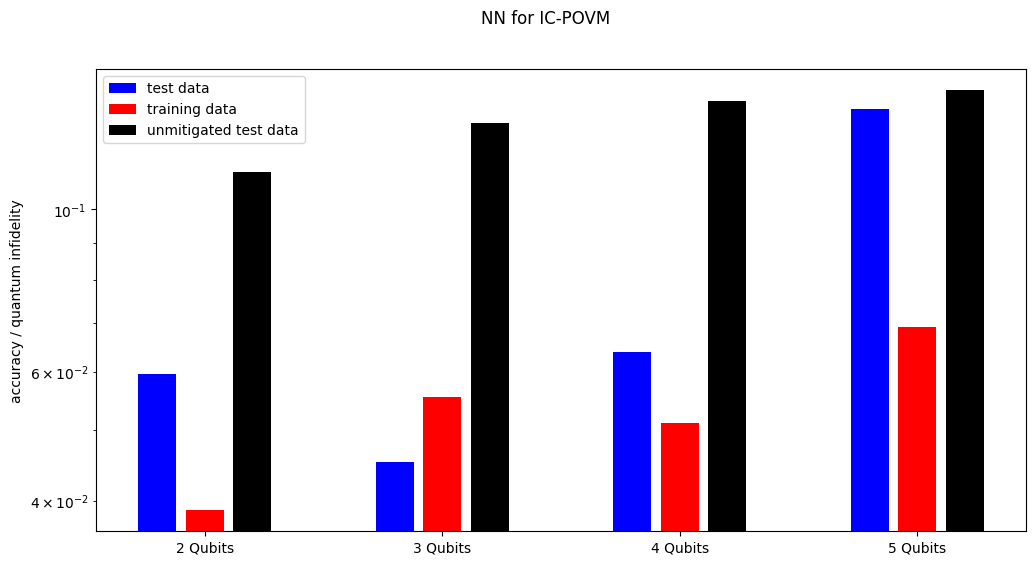

In [19]:
# Plotting the results
labels = ["2 Qubits","3 Qubits","4 Qubits","5 Qubits"]
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(0,acc_test_list[0][-1],label="test data",color="blue")
ax.bar(1,acc_train_list[0][-1],label="training data",color="red")
ax.bar(2,acc_unmit_list[0][-1],label="unmitigated test data",color="black")
ax.bar(5,acc_test_list[1][-1],color="blue")
ax.bar(6,acc_train_list[1][-1],color="red")
ax.bar(7,acc_unmit_list[1][-1],color="black")
ax.bar(10,acc_test_list[2][-1],color="blue")
ax.bar(11,acc_train_list[2][-1],color="red")
ax.bar(12,acc_unmit_list[2][-1],color="black")
ax.bar(15,acc_test_list[3][-1],color="blue")
ax.bar(16,acc_train_list[3][-1],color="red")
ax.bar(17,acc_unmit_list[3][-1],color="black")
ax.set_xticks([1,6,11,16])
ax.set_xticklabels(labels)
ax.set_yscale('log')
ax.set_xlabel("")
ax.set_ylabel("accuracy / quantum infidelity")
ax.legend()

fig.suptitle('NN for IC-POVM')

In [20]:
print("infidelity for unmitigated data for 2 qubis:", acc_unmit_list[0][-1])
print("infidelity for unmitigated data for 3 qubis:", acc_unmit_list[1][-1])
print("infidelity for unmitigated data for 4 qubis:", acc_unmit_list[2][-1])
print("infidelity for unmitigated data for 5 qubis:", acc_unmit_list[3][-1])

infidelity for unmitigated data for 2 qubis: 0.1125
infidelity for unmitigated data for 3 qubis: 0.13125
infidelity for unmitigated data for 4 qubis: 0.140625
infidelity for unmitigated data for 5 qubis: 0.1453125
